In [24]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from autoray import do

def get_bond_dim(tensor1, tensor2):
    """
    Get the bond dimension between two tensors.
    """
    # Get the indices that are shared between the two tensors
    shared_inds = set(tensor1.inds) & set(tensor2.inds)
    # Get the size of the shared indices
    shared_inds_size = [tensor1.ind_size(ind) for ind in shared_inds]
    # Return the product of the shared indices size
    return np.prod(shared_inds_size)


def get_neighbor_tensor_message(tn, messages, tensor, ind):
    """
    Get the neighbor tensor of current tensor on bond ind and a copy of corresponding messages.
    Messages is a dict, key is a tensor, value is a dict of message vectors connected to the tensor with keys being the bond indices.

    Parameters
    ----------
    tn : TensorNetwork
        The tensor network.
    messages : dict
        The set of all message vectors connected to the on-site nodes.
        A dict of messages, key is a tensor, value is a dict of message vectors connected to the tensor with keys being the bond indices.
    tensor : Tensor
        The tensor to get neighbor tensor and corresponding messages.
    ind : str
        The index of the tensor bond to get neighbor tensor and corresponding messages.
    
    Returns
    -------
    neighbor_tensor : Tensor
        The neighbor tensor of current tensor on bond ind.
    neighbor_tensor_messages : dict
        The messages of neighbor tensor, key is the bond index of the neighbor tensor, value is the message vector.
    """
    neighbor_tensor = None
    neighbor_tensor_message = None
    oset = list(tn.ind_map[ind])
    for no in oset:
        if tn.tensor_map[no] != tensor:
            neighbor_tensor = tn.tensor_map[no]
            neighbor_tensor_message = messages[neighbor_tensor].copy()
            break
    
    return neighbor_tensor, neighbor_tensor_message

def get_neighbor_tensor_message_for_bp(tn, messages, tensor, ind):
    """
    Get the neighbor tensor of current tensor on bond ind and corresponding messages.
    The returned neighbor tensor messages do not include the message from current tensor.
    Used for belief propagation messages update.
    """
    neighbor_tensor, neighbor_tensor_message = get_neighbor_tensor_message(tn, messages, tensor, ind)
    neighbor_tensor_message.pop(ind)
    return neighbor_tensor, neighbor_tensor_message


def get_messages_from_tn(tn):
    """
    Return a dict of messages, key is a tensor, value is a dict of message tensors connected to the tensor.
    """
    from autoray import do
    messages = {}
    for tensor in tn: # Iterate over all tensors in the tensor network, general for tensor network on general graph.
        message = {}
        for ind in tensor.inds:# Do not distinguish inner indices and outer indices. TODO: distinguish inner indices and outer indices.
            message_data = do('ones', [tensor.ind_size(ind)], like=tensor.data)
            norm = do('linalg.norm', message_data, like=tensor.data)
            message_data /= norm
            message_ind = (str(ind),)
            message_tags = tn.ind_map[ind]
            message[ind] = qtn.Tensor(data=message_data, inds=message_ind, tags=message_tags)
        messages[tensor] = message # TODO: The key of messages is a tensor, which can be improved to be a tensor id to save memory.
    return messages





def loopy_belief_propagation(tn, max_iter=100, tol=1e-6, fixed_iter=False,progbar=True):
    """
    Perform loopy belief propagation on a tensor network.

    Parameters
    ----------
    tn : TensorNetwork object in quimb.tensor
        The tensor network on which to perform loopy belief propagation.
    max_iter : int, optional
        The maximum number of iterations to perform.
    tol : float, optional
        The tolerance for convergence.

    Returns
    -------
    dict
        Key is the on-site tensor, value is a dict of message tensors connected to the tensor with keys being the bond indices.
        Include all tensors and corresponding messages in the tensor network.
    """
    # Initialize messages
    messages = get_messages_from_tn(tn)
    
    # Iterate until convergence or maximum iterations
    # Use the old messages to calculate the new messages
    if progbar:
        import tqdm

        it = tqdm.tqdm(range(max_iter))
    else:
        it = range(max_iter)

    converged_ind = set()
    for _ in range(max_iter):
        for tensor in tn:
            for ind in tensor.inds:
                old_message_data = messages[tensor][ind].data
                # Obatin the new message from the belief propagation equations
                neighbor_tensor, neighbor_tensor_message = get_neighbor_tensor_message(tn, messages, tensor, ind)
                neighbor_tensor_message.pop(ind) # Remove the message from current tensor

                t_list = [neighbor_tensor]
                for _,message in neighbor_tensor_message.items():
                    t_list.append(message)
                
                new_message = qtn.TensorNetwork(t_list, virtual=False)
                new_message_contracted = new_message.contract()

                # Normalize the new message
                norm = do('linalg.norm', new_message_contracted.data, like=new_message_contracted.data)
                new_message_data = new_message_contracted.data/norm

                # Update the message
                messages[tensor][ind].modify(data=new_message_data)

                # Check for convergence
                if np.linalg.norm(np.array(new_message_data) - np.array(old_message_data)) < tol:
                    converged_ind.add(ind)
                # print(new_message_tensor.data,old_message_data)
                
        if len(converged_ind) == len(tn.ind_map) and not fixed_iter:
            print(f'Converged!')
            return messages
        if progbar:
            it.set_description(f"Converged inds:{len(converged_ind)}", refresh=False)

    if fixed_iter and len(converged_ind) == len(tn.ind_map):
        print('Converged!')
        return messages
    
    # Not converged
    print('Not converged!')
    return messages


def partition_func_numerator(final_messages):
    contraction_bp = 1
    for tensor, messages in final_messages.items():
        t_list = [tensor]
        for _,message in messages.items():
            t_list.append(message)
        t = qtn.TensorNetwork(t_list, virtual=False)
        contraction_bp *= t.contract()
    return contraction_bp
def partition_func_denominator(final_messages, tn):
    contraction_bp = 1
    for ind,oset in tn.ind_map.items():
        t1 = tn.tensor_map[list(oset)[0]]
        t2 = tn.tensor_map[list(oset)[1]]
        message1 = final_messages[t1][ind]
        message2 = final_messages[t2][ind]
        contraction_bp *= (message1 & message2).contract()
    return contraction_bp
        
def compare_bp_exact_2d(Lx,Ly,beta,tol=1e-6,max_iter=1000,fix_iter=False,cyclic=False):    
    partition_tn = qtn.tensor_builder.TN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta,cyclic=cyclic)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fix_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    Z_exact = partition_tn.contract()
    relative_err=np.abs(np.log(Z_exact)-np.log(Z))/np.log(Z_exact)
    return relative_err, Z, Z_exact

def exact_partition_function(Lx,Ly,beta,cyclic=False):
    partition_tn = qtn.tensor_builder.TN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta,cyclic=cyclic)
    Z_exact = partition_tn.contract()
    return Z_exact

def bp_partition_function(Lx,Ly,beta,max_iter=1000,tol=1e-6,fixed_iter=False,cyclic=False):
    partition_tn = qtn.tensor_builder.TN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta,cyclic=cyclic)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fixed_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    return Z

def compare_bp_exact_3d(Lx,Ly,Lz,beta,tol=1e-6,max_iter=1000,fix_iter=False,cyclic=False):    
    partition_tn = qtn.tensor_builder.TN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta,cyclic=cyclic)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fix_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    Z_exact = partition_tn.contract()
    relative_err=np.abs(np.log(Z_exact)-np.log(Z))/np.log(Z_exact)
    return relative_err, Z, Z_exact

def exact_partition_function_3d(Lx,Ly,Lz,beta,cyclic=False):
    partition_tn = qtn.tensor_builder.TN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta,cyclic=cyclic)
    Z_exact = partition_tn.contract()
    return Z_exact

def bp_partition_function_3d(Lx,Ly,Lz,beta,max_iter=1000,tol=1e-6,fixed_iter=False,cyclic=False):
    partition_tn = qtn.tensor_builder.TN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta,cyclic=cyclic)
    messages = loopy_belief_propagation(partition_tn, max_iter=max_iter, tol=tol, fixed_iter=fixed_iter)
    Z = partition_func_numerator(messages)/partition_func_denominator(messages, partition_tn)
    return Z

#----------------------------------------------------------------------------------------------------------------------------#


import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp

def contract_HTN_partition(tn):
    """
    Exactly contract the hyper tensor network to get the partition function.
    """
    import quimb.tensor as qtn
    tensor_list = []
    for tensor in tn.tensor_map.values():
        tensor_list.append(tensor)
    value = qtn.tensor_contract(*tensor_list, output_inds=[])
    return value

def compare_bp_exact_HTN_tree(Lx,Ly,Lz=0,beta=0.5,tol=1e-10, damping=False, eta=1e-1, messages_input=None, tn_input=None):
    """"""
    if tn_input is None:
        if Lz==0:
            # 2D
            tn = qtn.tensor_builder.HTN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta)
        else:
            # 3D
            tn = qtn.tensor_builder.HTN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
    else:
        tn = tn_input.copy()
    
    tn.hyperinds_resolve_('tree','clustering')
    # Exact
    Z_exact = contract_HTN_partition(tn)
    entropy_exact = np.log(Z_exact)
    
    
    # BP
    converged = False
    while not converged:
        messages, converged = qbp.run_belief_propagation(
        tn, 
        messages=messages_input,
        tol=tol,
        max_iterations=4000, 
        progbar=True,
        # you can parallelize but its not super efficient
        thread_pool=False,
        uniform=False,
        damping=damping,
        eta=eta,
        )
        if not converged:
            messages_input = None
    entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
    Z_bp =np.exp(entropy_bp)

    err = np.abs(entropy_exact-entropy_bp)/entropy_exact

    return err, Z_bp, Z_exact, entropy_bp, entropy_exact, messages

def compare_bp_exact_HTN_dense(Lx,Ly,Lz=0,beta=0.5,tol=1e-10, damping=False, eta=1e-1, messages_input=None, tn_input=None):
    """"""
    if tn_input is None:
        if Lz==0:
            # 2D
            tn = qtn.tensor_builder.HTN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta)
        else:
            # 3D
            tn = qtn.tensor_builder.HTN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
    else:
        tn = tn_input.copy()
    tn.hyperinds_resolve_('dense','clustering')
    # Exact
    Z_exact = contract_HTN_partition(tn)
    entropy_exact = np.log(Z_exact)
    
    # BP
    converged = False
    while not converged:
        messages, converged = qbp.run_belief_propagation(
        tn, 
        messages=messages_input,
        tol=tol,
        max_iterations=4000, 
        progbar=True,
        # you can parallelize but its not super efficient
        thread_pool=False,
        uniform=False,
        damping=damping,
        eta=eta,
        )
        if not converged:
            messages_input = None
    entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
    Z_bp =np.exp(entropy_bp)

    err = np.abs(entropy_exact-entropy_bp)/entropy_exact

    return err, Z_bp, Z_exact, entropy_bp, entropy_exact, messages

def compare_bp_exact_HTN(Lx,Ly,Lz=0,beta=0.5,tol=1e-10, damping=False, eta=1e-1, messages_input=None, tn_input=None):
    """"""
    if tn_input is None:
        if Lz==0:
            # 2D
            tn = qtn.tensor_builder.HTN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta)
        else:
            # 3D
            tn = qtn.tensor_builder.HTN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
    else:
        tn = tn_input.copy()

    # Exact
    Z_exact = contract_HTN_partition(tn)
    entropy_exact = np.log(Z_exact)
    
    # BP
    converged = False
    while not converged:
        messages, converged = qbp.run_belief_propagation(
        tn, 
        messages=messages_input,
        tol=tol,
        max_iterations=4000, 
        progbar=True,
        # you can parallelize but its not super efficient
        thread_pool=False,
        uniform=False,
        damping=damping,
        eta=eta,
        )
        if not converged:
            messages_input = None
    entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
    Z_bp =np.exp(entropy_bp)

    err = np.abs(entropy_exact-entropy_bp)/entropy_exact

    return err, Z_bp, Z_exact, entropy_bp, entropy_exact, messages

def compare_bp_exact_HTN_mps(Lx,Ly,Lz=0,beta=0.5,tol=1e-10, damping=False, eta=1e-1, messages_input=None, tn_input=None):
    """"""
    if tn_input is None:
        if Lz==0:
            # 2D
            tn = qtn.tensor_builder.HTN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta)
        else:
            # 3D
            tn = qtn.tensor_builder.HTN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
    else:
        tn = tn_input.copy()
    tn.hyperinds_resolve_('mps','clustering')
    # Exact
    Z_exact = contract_HTN_partition(tn)
    entropy_exact = np.log(Z_exact)
    
    # BP
    converged = False
    while not converged:
        messages, converged = qbp.run_belief_propagation(
        tn, 
        messages=messages_input,
        tol=tol,
        max_iterations=4000, 
        progbar=True,
        # you can parallelize but its not super efficient
        thread_pool=False,
        uniform=False,
        damping=damping,
        eta=eta,
        )
        if not converged:
            messages_input = None
    entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)
    Z_bp =np.exp(entropy_bp)

    err = np.abs(entropy_exact-entropy_bp)/entropy_exact

    return err, Z_bp, Z_exact, entropy_bp, entropy_exact, messages

def update_tn(tn_old, Lx,Ly,Lz,beta):
    tn = tn_old.copy()
    if Lz==0:
        tn_new = qtn.tensor_builder.HTN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta)
        for i in range(len(tn.tensors)):
            tn.tensors[i].modify(data = tn_new.tensors[i].data)
    else:
        tn_new = qtn.tensor_builder.HTN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta)
        for i in range(len(tn.tensors)):
            tn.tensors[i].modify(data = tn_new.tensors[i].data)
    return tn

### 2D classical Ising model

In [16]:
def plot_2d_Ising(Lx,Ly,Lz,tol,damping,eta):
    err_list_2d = []
    exact_Z_list_2d = []
    bp_Z_list_2d = []
    HTN_exact_Z_list_2d = []
    HTN_bp_Z_list_2d = []
    HTN_exact_entropy_list_2d = []
    HTN_bp_entropy_list_2d = []
    HTN_err_list_2d = []
    HTN_dense_err_list_2d = []
    HTN_original_err_list_2d = []
    HTN_mps_err_list_2d = []
    beta_list = np.linspace(0.1,1,10)
    messages_original= None

    tn = qtn.tensor_builder.HTN2D_classical_ising_partition_function(Lx=Lx,Ly=Ly,beta=beta_list[0])
    for beta in beta_list:
        tn = update_tn(tn, Lx,Ly,Lz,beta)
        err, bp_Z, exact_Z = compare_bp_exact_2d(Lx,Ly,beta,fix_iter=False,tol=1e-20)
        HTN_err, HTN_bp_Z, HTN_exact_Z, HTN_bp_entropy, HTN_exact_entropy, messages_tree, = compare_bp_exact_HTN_tree(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta)
        HTN_err_dense, _, _, _, _,messages_dense, = compare_bp_exact_HTN_dense(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta)
        # HTN_err_original, _, _, _, _,new_messages_original, = compare_bp_exact_HTN(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta,tn_input=tn,messages_input=messages_original)
        HTN_err_original, _, _, _, _,new_messages_original, = compare_bp_exact_HTN(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta,tn_input=tn,messages_input=None)
        HTN_err_mps, _, _, _, _,messages_mps, = compare_bp_exact_HTN_mps(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta)
        
        messages_original = new_messages_original
        

        err_list_2d.append(err)
        exact_Z_list_2d.append(exact_Z)
        bp_Z_list_2d.append(bp_Z)
        HTN_exact_Z_list_2d.append(HTN_exact_Z)
        HTN_bp_Z_list_2d.append(HTN_bp_Z)
        HTN_exact_entropy_list_2d.append(HTN_exact_entropy)
        HTN_bp_entropy_list_2d.append(HTN_bp_entropy)
        
        HTN_err_list_2d.append(HTN_err)
        HTN_dense_err_list_2d.append(HTN_err_dense)
        HTN_original_err_list_2d.append(HTN_err_original)
        HTN_mps_err_list_2d.append(HTN_err_mps)

    import matplotlib.pyplot as pLy
    ax = pLy.subplot(111)
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'Relative error of free energy')
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.plot(beta_list, err_list_2d, label='Bethe: Normal-TN',marker='o')
    ax.plot(beta_list, HTN_original_err_list_2d, label='Bethe: Hyper-TN',marker='o')
    ax.plot(beta_list, HTN_dense_err_list_2d, label='Bethe: Hyper-TN-COPY-Dense',marker='o')
    ax.plot(beta_list, HTN_err_list_2d, label='Bethe: Hyper-TN-COPY-Tree',marker='o')
    ax.plot(beta_list, HTN_mps_err_list_2d, label='Bethe: Hyper-TN-COPY-MPS',marker='o')
    # plot phase transition point 
    ax.axvline(x=0.440686793509771, color='r', linestyle='--', label='Exact Phase Transition Point')
    pLy.legend()
    pLy.title(r'L={} 2d classical Ising: BP with damping $\eta = {}$'.format(Lx,eta))
    pLy.show()

Converged inds:170:   0%|          | 0/1000 [00:00<?, ?it/s]


Converged!


Converged inds:179:   0%|          | 0/1000 [00:00<?, ?it/s]


Converged!


Converged inds:179:   0%|          | 0/1000 [00:00<?, ?it/s]


Converged!


Converged inds:179:   0%|          | 0/1000 [00:00<?, ?it/s]


Converged!


Converged inds:179:   0%|          | 0/1000 [00:00<?, ?it/s]


Converged!


Converged inds:179:   0%|          | 0/1000 [00:02<?, ?it/s]


Converged!


Converged inds:177:   0%|          | 0/1000 [00:01<?, ?it/s]


Converged!


Converged inds:179:   0%|          | 0/1000 [00:01<?, ?it/s]


Converged!


Converged inds:177:   0%|          | 0/1000 [00:01<?, ?it/s]


Converged!


Converged inds:177:   0%|          | 0/1000 [00:01<?, ?it/s]


Converged!


max_dm=9.985345883478658e-13:   3%|▎         | 103/4000 [00:00<00:01, 2521.54it/s]


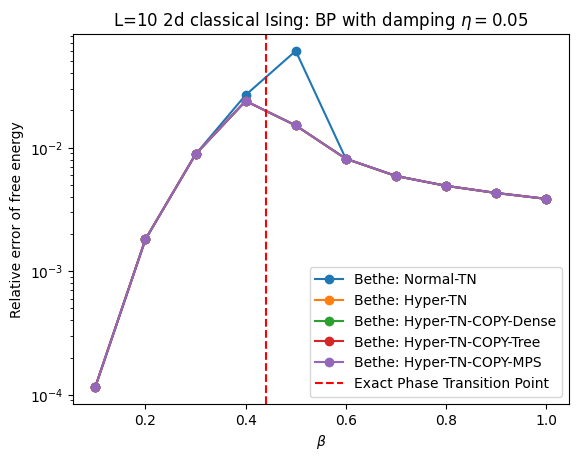

In [23]:
plot_2d_Ising(Lx=10,Ly=10,Lz=0,tol=1e-12,damping=False,eta=5e-2)

### 3D classical Ising model

In [81]:
def plot_3d_Ising(Lx,Ly,Lz,tol,damping,eta):
    err_list_3d = []
    exact_Z_list_3d = []
    bp_Z_list_3d = []
    HTN_exact_Z_list_3d = []
    HTN_bp_Z_list_3d = []
    HTN_exact_entropy_list_3d = []
    HTN_bp_entropy_list_3d = []
    HTN_err_list_3d = []
    HTN_dense_err_list_3d = []
    HTN_original_err_list_3d = []
    HTN_mps_err_list_3d = []
    beta_list = np.linspace(0.1,1,10)
    messages_original= None

    tn = qtn.tensor_builder.HTN3D_classical_ising_partition_function(Lx=Lx,Ly=Ly,Lz=Lz,beta=beta_list[0])
    for beta in beta_list:
        tn = update_tn(tn, Lx,Ly,Lz,beta)
        err, bp_Z, exact_Z = compare_bp_exact_3d(Lx,Ly,Lz,beta,fix_iter=False,tol=1e-20)
        HTN_err, HTN_bp_Z, HTN_exact_Z, HTN_bp_entropy, HTN_exact_entropy, messages_tree, = compare_bp_exact_HTN_tree(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta)
        HTN_err_dense, _, _, _, _,messages_dense, = compare_bp_exact_HTN_dense(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta)
        HTN_err_original, _, _, _, _,new_messages_original, = compare_bp_exact_HTN(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta,tn_input=tn,messages_input=messages_original)
        HTN_err_mps, _, _, _, _,messages_mps, = compare_bp_exact_HTN_mps(Lx,Ly,Lz,beta,tol=tol, damping=damping, eta=eta)
        
        messages_original = new_messages_original
        

        err_list_3d.append(err)
        exact_Z_list_3d.append(exact_Z)
        bp_Z_list_3d.append(bp_Z)
        HTN_exact_Z_list_3d.append(HTN_exact_Z)
        HTN_bp_Z_list_3d.append(HTN_bp_Z)
        HTN_exact_entropy_list_3d.append(HTN_exact_entropy)
        HTN_bp_entropy_list_3d.append(HTN_bp_entropy)
        
        HTN_err_list_3d.append(HTN_err)
        HTN_dense_err_list_3d.append(HTN_err_dense)
        HTN_original_err_list_3d.append(HTN_err_original)
        HTN_mps_err_list_3d.append(HTN_err_mps)

    import matplotlib.pyplot as pLy
    ax = pLy.subplot(111)
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'Relative error of free energy')
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.plot(beta_list, err_list_3d, label='Bethe: Normal-TN',marker='o')
    ax.plot(beta_list, HTN_original_err_list_3d, label='Bethe: Hyper-TN',marker='o')
    ax.plot(beta_list, HTN_dense_err_list_3d, label='Bethe: Hyper-TN-COPY-Dense',marker='o')
    ax.plot(beta_list, HTN_err_list_3d, label='Bethe: Hyper-TN-COPY-Tree',marker='o')
    ax.plot(beta_list, HTN_mps_err_list_3d, label='Bethe: Hyper-TN-COPY-MPS',marker='o')
    # plot phase transition point 
    # ax.axvline(x=0.440686793509771, color='r', linestyle='--', label='Exact Phase Transition Point')
    pLy.legend()
    pLy.title(r'L=4 3D classical Ising: BP with damping $\eta = {}$'.format(eta))
    pLy.show()

Converged!


9.597878047884478e-14:  29%|██▉       | 582/2000 [00:00<00:00, 3237.53it/s] 


Converged!


9.331424521974441e-14:  18%|█▊        | 361/2000 [00:00<00:00, 3235.47it/s]


Converged!


9.486855745421963e-14:  26%|██▌       | 514/2000 [00:00<00:00, 3571.40it/s] 


Converged!


8.776313009661862e-14:   7%|▋         | 149/2000 [00:00<00:00, 2585.25it/s]


Converged!


9.875433804040767e-14:  13%|█▎        | 264/2000 [00:00<00:00, 2550.89it/s] 


Converged!


8.251732630526476e-14:   8%|▊         | 159/2000 [00:00<00:00, 2142.86it/s]


Converged!


8.654188476953095e-14:  24%|██▎       | 474/2000 [00:00<00:00, 3151.25it/s]


Converged!


8.179568133925841e-14:  32%|███▏      | 647/2000 [00:00<00:00, 3942.54it/s]


Converged!


9.928169397710462e-14:   5%|▍         | 99/2000 [00:00<00:01, 1657.98it/s]


Converged!


9.611755835692293e-14:   7%|▋         | 132/2000 [00:00<00:00, 2102.10it/s]


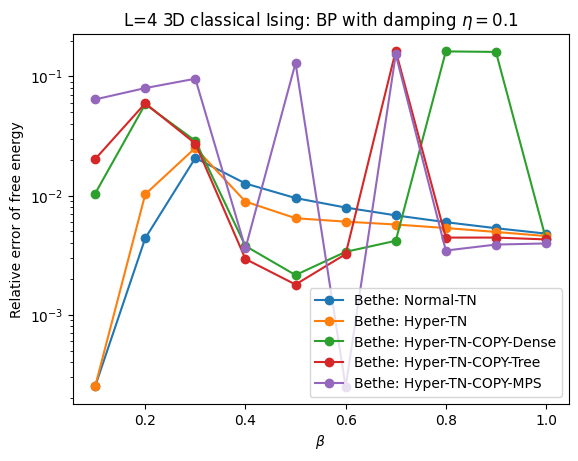

In [77]:
plot_3d_Ising(Lx=4,Ly=4,Lz=4,tol=1e-13,damping=True,eta=0.1)

Converged!


9.764411501578252e-14:  27%|██▋       | 533/2000 [00:00<00:00, 3430.47it/s] 


Converged!


9.581224702515101e-14:  30%|███       | 610/2000 [00:00<00:00, 3538.98it/s]


Converged!


9.764411501578252e-14:  12%|█▏        | 234/2000 [00:00<00:00, 2989.43it/s]


Converged!


9.831024883055761e-14:  30%|███       | 609/2000 [00:00<00:00, 3565.22it/s] 


Converged!


9.212075546827236e-14:   6%|▌         | 115/2000 [00:00<00:00, 2625.31it/s]


Converged!


7.482903185973555e-14:   5%|▌         | 105/2000 [00:00<00:01, 1707.24it/s]


Converged!


9.967027203572343e-14:   6%|▌         | 115/2000 [00:00<00:00, 2541.92it/s]


Converged!


8.551492847175268e-14:   4%|▍         | 78/2000 [00:00<00:00, 3295.88it/s]


Converged!


9.384160115644136e-14:   4%|▎         | 73/2000 [00:00<00:00, 2749.38it/s]


Converged!


6.15341111398493e-14:   6%|▌         | 124/2000 [00:00<00:00, 2826.27it/s]


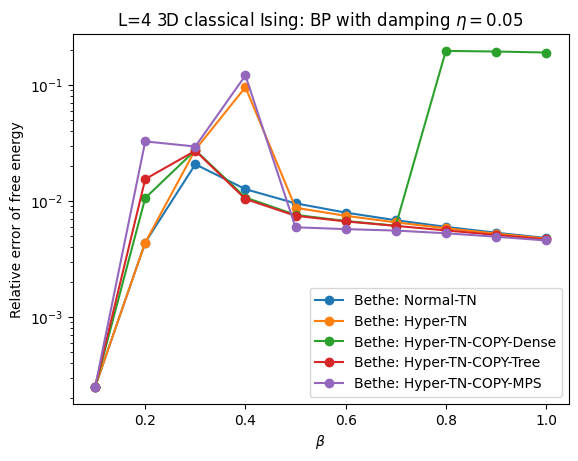

In [74]:
plot_3d_Ising(Lx=4,Ly=4,Lz=4,tol=1e-13,damping=True,eta=5e-2)

Converged!


9.908740494779522e-14:   7%|▋         | 138/2000 [00:00<00:00, 2103.97it/s]


Converged!


9.614531393253856e-14:  24%|██▍       | 484/2000 [00:00<00:00, 3327.85it/s]


Converged!


9.764411501578252e-14:  22%|██▏       | 449/2000 [00:00<00:00, 3128.40it/s]


Converged!


9.425793479067579e-14:   8%|▊         | 168/2000 [00:00<00:00, 2412.86it/s]


Converged!


8.62088178621434e-14:   6%|▌         | 117/2000 [00:00<00:00, 2852.89it/s]


Converged!


9.259260025373806e-14:   5%|▍         | 98/2000 [00:00<00:01, 1885.09it/s]


Converged!


6.836198274129401e-14:   4%|▍         | 82/2000 [00:00<00:01, 1596.50it/s]


Converged!


7.904787935331115e-14:   3%|▎         | 69/2000 [00:00<00:00, 1972.10it/s]


Converged!


7.149836278586008e-14:   4%|▎         | 71/2000 [00:00<00:01, 1919.27it/s]


Converged!


8.069933610244107e-14:   3%|▎         | 64/2000 [00:00<00:00, 2994.09it/s]


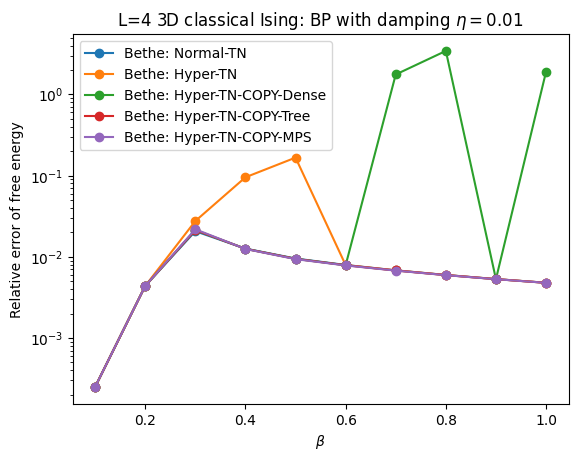

In [83]:
plot_3d_Ising(Lx=4,Ly=4,Lz=4,tol=1e-13,damping=True,eta=1e-2)

Converged!


9.869882688917642e-14:  11%|█         | 217/2000 [00:00<00:00, 2870.21it/s]


Converged!


9.992007221626409e-14:  78%|███████▊  | 1552/2000 [00:00<00:00, 3828.59it/s]


Converged!


9.94482274307984e-14:  15%|█▌        | 308/2000 [00:00<00:00, 3221.77it/s]


Converged!


9.064970996064403e-14:   9%|▊         | 174/2000 [00:00<00:00, 2600.38it/s]


Converged!


8.790190797469677e-14:   6%|▋         | 126/2000 [00:00<00:00, 2621.69it/s]


Converged!


7.416289804496046e-14:   5%|▍         | 99/2000 [00:00<00:00, 2526.21it/s]


Converged!


8.751332991607796e-14:   4%|▍         | 83/2000 [00:00<00:00, 2099.77it/s]


Converged!


8.573697307667771e-14:   4%|▍         | 77/2000 [00:00<00:00, 2593.19it/s]


Converged!


9.731104810839497e-14:   3%|▎         | 63/2000 [00:00<00:00, 3275.54it/s]


Converged!


7.321920847402907e-14:   3%|▎         | 65/2000 [00:00<00:00, 2361.39it/s]


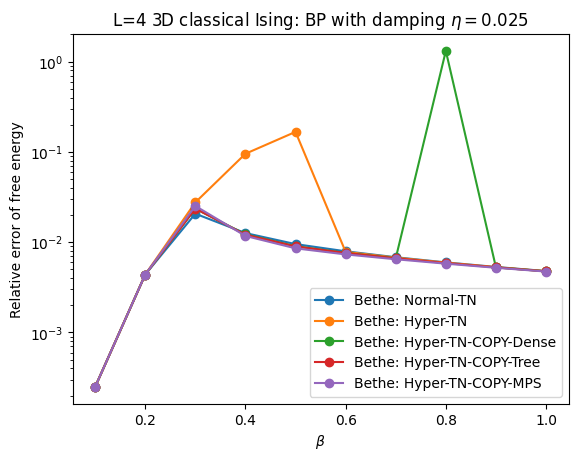

In [82]:
plot_3d_Ising(Lx=4,Ly=4,Lz=4,tol=1e-13,damping=True,eta=0.025)

Converged!


9.298117831235686e-14:   8%|▊         | 167/2000 [00:00<00:00, 2573.38it/s]


Converged!


9.675593659608239e-14:  32%|███▏      | 639/2000 [00:00<00:00, 3784.84it/s]


Converged!


9.567346914707286e-14:  22%|██▏       | 430/2000 [00:00<00:00, 3467.93it/s]


Converged!


9.434120151752268e-14:   9%|▉         | 176/2000 [00:00<00:00, 2811.50it/s]


Converged!


9.822698210371072e-14:   6%|▋         | 126/2000 [00:00<00:00, 2386.36it/s]


Converged!


9.844902670863576e-14:   5%|▌         | 107/2000 [00:00<00:00, 2597.69it/s]


Converged!


7.968625759247061e-14:   5%|▍         | 91/2000 [00:00<00:00, 2460.89it/s]


Converged!


6.933342788784103e-14:   5%|▌         | 104/2000 [00:00<00:00, 2318.14it/s]


Converged!


7.632783294297951e-14:   4%|▎         | 71/2000 [00:00<00:00, 2805.45it/s]


Converged!


9.336975637097567e-14:  10%|█         | 206/2000 [00:00<00:00, 4110.87it/s]


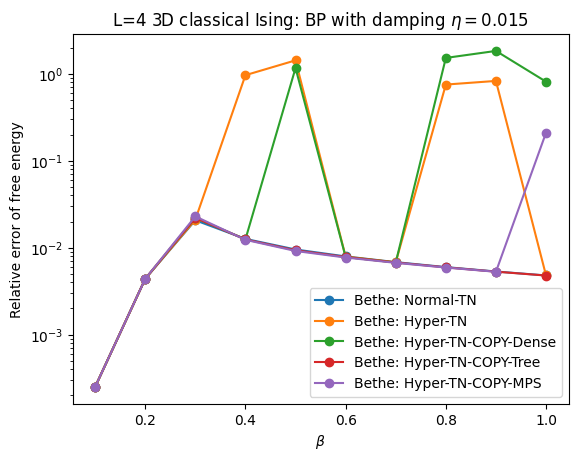

In [12]:
plot_3d_Ising(Lx=4,Ly=4,Lz=4,tol=1e-13,damping=True,eta=0.015)

Interestingly, if we initialize the messages randomly and use a higher tol for HTN BP, they converge faster and the results are more accurate.

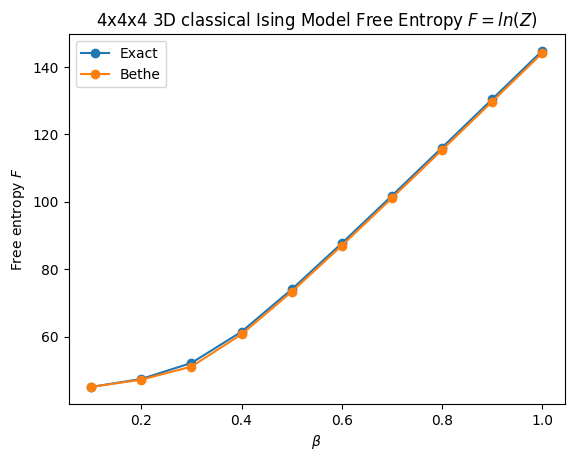

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
exact_F_list_3d = np.log(exact_Z_list_3d)
bp_F_list_3d = np.log(bp_Z_list_3d)
ax2 = plt.subplot(111)
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'Free entropy $F$')
ax2.plot(beta_list, exact_F_list_3d, label='Exact',marker='o',color=colors[0])
ax2.plot(beta_list, bp_F_list_3d, label='Bethe',marker='o',color=colors[1])
plt.title(r'4x4x4 3D classical Ising Model Free Entropy $F=ln(Z)$')
plt.legend()

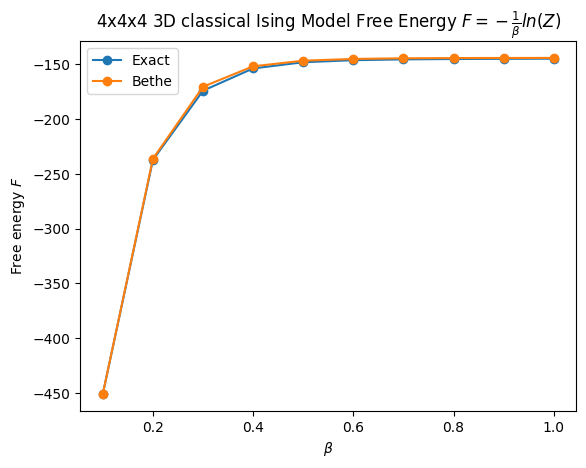

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
exact_F_list_3d = -np.log(exact_Z_list_3d)/beta_list
bp_F_list_3d = -np.log(bp_Z_list_3d)/beta_list
ax2 = plt.subplot(111)
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'Free energy $F$')
ax2.plot(beta_list, exact_F_list_3d, label='Exact',marker='o',color=colors[0])
ax2.plot(beta_list, bp_F_list_3d, label='Bethe',marker='o',color=colors[1])
plt.title(r'4x4x4 3D classical Ising Model Free Energy $F=-\frac{1}{\beta}ln(Z)$')
plt.legend()

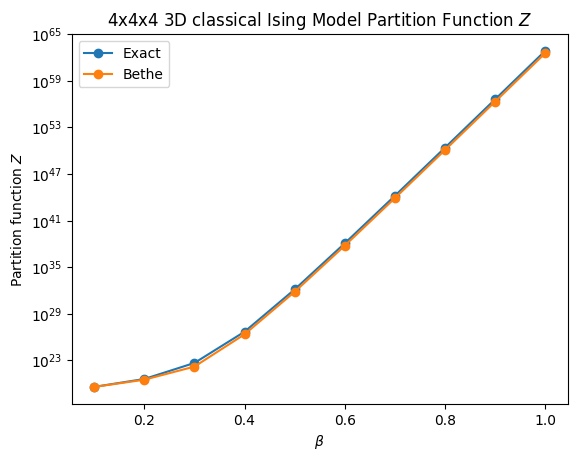

In [9]:
ax1 = plt.subplot(111)
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel(r'Partition function $Z$')
ax1.set_yscale('log')
ax1.plot(beta_list, exact_Z_list_3d, label='Exact',marker='o')
ax1.plot(beta_list, bp_Z_list_3d, label='Bethe',marker='o')
plt.legend()
plt.title(r'4x4x4 3D classical Ising Model Partition Function $Z$')
plt.show()

### 2D classical Ising model

In [40]:
err_list = []
exact_Z_list = []
bp_Z_list = []
HTN_exact_Z_list = []
HTN_bp_Z_list = []
HTN_exact_entropy_list = []
HTN_bp_entropy_list = []
HTN_err_list = []
beta_list = np.linspace(0.1,1,10)
for beta in beta_list:
    err, bp_Z, exact_Z = compare_bp_exact_2d(10,10,beta,fix_iter=True,tol=1e-25)
    # HTN_err, HTN_bp_Z, HTN_exact_Z, HTN_bp_entropy, HTN_exact_entropy, _ = compare_bp_exact_HTN(10,10,beta=beta,tol=1e-12)
    err_list.append(err)
    exact_Z_list.append(exact_Z)
    bp_Z_list.append(bp_Z)
    # HTN_exact_Z_list.append(HTN_exact_Z)
    # HTN_bp_Z_list.append(HTN_bp_Z)
    # HTN_exact_entropy_list.append(HTN_exact_entropy)
    # HTN_bp_entropy_list.append(HTN_bp_entropy)
    # HTN_err_list.append(HTN_err)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:27<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]

Converged!



Converged inds:180:   0%|          | 0/1000 [00:25<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]


Converged!


Converged inds:180:   0%|          | 0/1000 [00:26<?, ?it/s]

Converged!


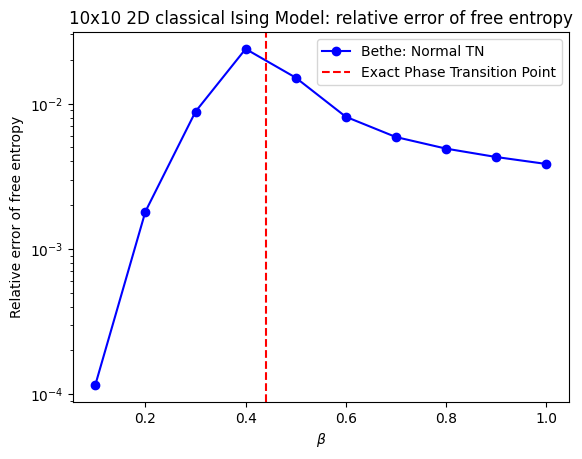

In [41]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'Relative error of free entropy')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.plot(beta_list, err_list, label='Bethe: Normal TN',marker='o',color='b')
# ax.plot(beta_list, HTN_err_list, label='Bethe: Hyper TN',marker='o',color='r')
# plot phase transition point 
ax.axvline(x=0.440686793509771, color='r', linestyle='--', label='Exact Phase Transition Point')
plt.title('10x10 2D classical Ising Model: relative error of free entropy')
plt.legend()
plt.show()

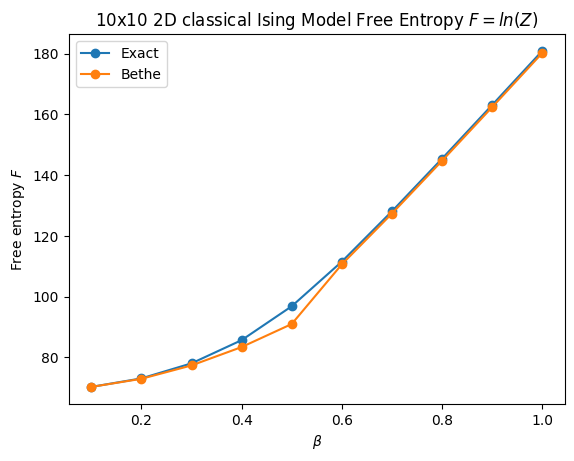

In [39]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
exact_F_list = np.log(exact_Z_list)
bp_F_list = np.log(bp_Z_list)
ax2 = plt.subplot(111)
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'Free entropy $F$')
ax2.plot(beta_list, exact_F_list, label='Exact',marker='o',color=colors[0])
ax2.plot(beta_list, bp_F_list, label='Bethe',marker='o',color=colors[1])
plt.title(r'10x10 2D classical Ising Model Free Entropy $F=ln(Z)$')
plt.legend()

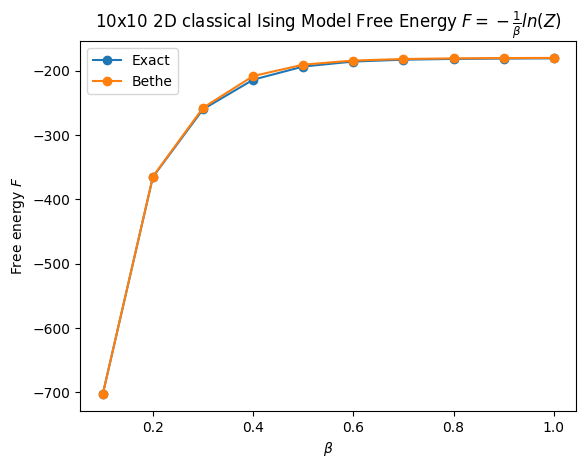

In [13]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
exact_F_list = -np.log(exact_Z_list)/beta_list
bp_F_list = -np.log(bp_Z_list)/beta_list
ax2 = plt.subplot(111)
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'Free energy $F$')
ax2.plot(beta_list, exact_F_list, label='Exact',marker='o',color=colors[0])
ax2.plot(beta_list, bp_F_list, label='Bethe',marker='o',color=colors[1])
plt.title(r'10x10 2D classical Ising Model Free Energy $F=-\frac{1}{\beta}ln(Z)$')
plt.legend()

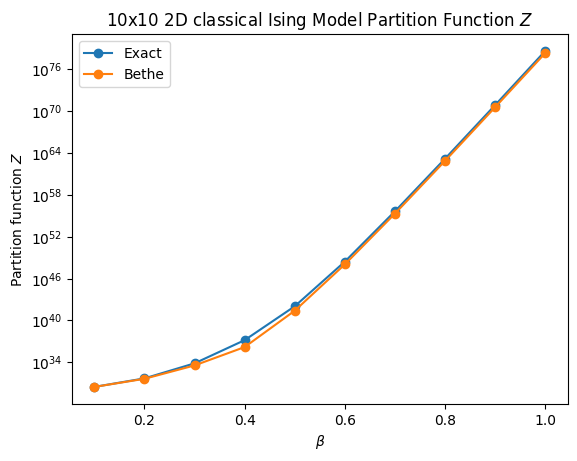

In [14]:
ax1 = plt.subplot(111)
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel(r'Partition function $Z$')
ax1.set_yscale('log')
ax1.plot(beta_list, exact_Z_list, label='Exact',marker='o')
ax1.plot(beta_list, bp_Z_list, label='Bethe',marker='o')
plt.legend()
plt.title(r'10x10 2D classical Ising Model Partition Function $Z$')
plt.show()

Periodic boundary conditions

In [22]:
err_list = []
exact_Z_list = []
bp_Z_list = []
beta_list = np.linspace(0.1,1,10)
for beta in beta_list:
    err, bp_Z, exact_Z = compare_bp_exact(10,10,beta,fix_iter=True,tol=1e-20,cyclic=True)
    err_list.append(err)
    exact_Z_list.append(exact_Z)
    bp_Z_list.append(bp_Z)


Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!


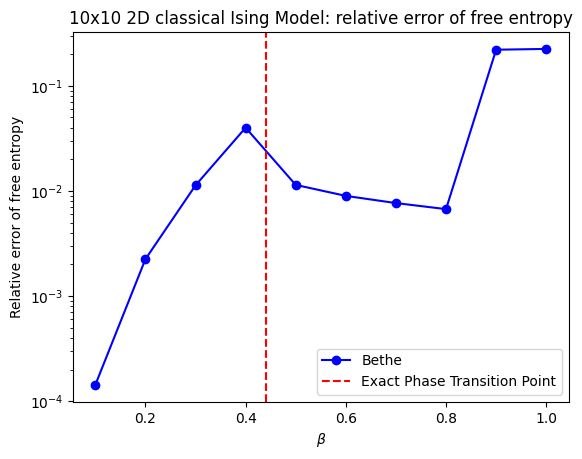

In [21]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'Relative error of free entropy')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.plot(beta_list, err_list, label='Bethe',marker='o',color='b')
# plot phase transition point 
ax.axvline(x=0.440686793509771, color='r', linestyle='--', label='Exact Phase Transition Point')
plt.title('10x10 2D classical Ising Model: relative error of free entropy')
plt.legend()
plt.show()

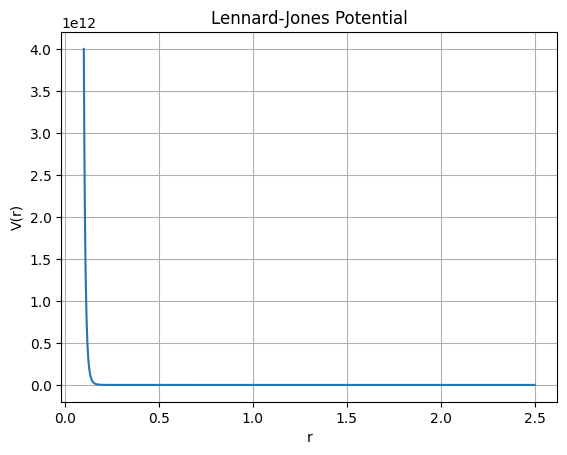

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the Lennard-Jones potential
epsilon = 1.0  # Depth of the potential well
sigma = 1.0    # Finite distance at which the inter-particle potential is zero

# Create an array of discrete r values (avoiding r=0 to prevent division by zero)
r = np.linspace(0.1, 2.5*sigma, 1000)

# Calculate the Lennard-Jones potential at each r value
V = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

# Plot the Lennard-Jones potential
plt.plot(r, V)
plt.xlabel('r')
plt.ylabel('V(r)')
plt.title('Lennard-Jones Potential')
plt.grid(True)
plt.show()
